In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191003130833-0000
KERNEL_ID = de36fdf3-ad99-4f9a-b27f-8c18ad75a219


# IEEE CIS Fraud Detection Feature Engineering and Modeling

In [2]:
# No need to feature engineer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pixiedust.display import *

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# Feature engineering for training
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('transaction_id_train_nonull.csv', 'default-donotdelete-pr-l16zufkrkht8vm'))

In [300]:
df_test = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('transaction_id_test_nonull.csv', 'default-donotdelete-pr-l16zufkrkht8vm'))

In [6]:
# place transaction id and target as first and second columns
cols = df.columns
a = ['TransactionID', 'isFraud']
cols = a + [i for i in cols if i not in a]
df2 = df.select(cols)

In [ ]:
display(df2)

In [16]:
df_train.groupBy('isFraud').count().show()

+-------+------+
|isFraud| count|
+-------+------+
|    1.0| 16533|
|    0.0|455709|
+-------+------+



In [64]:
16538/455662

0.0362944463220545

In [72]:
# sample

fractions = {'0.0': 0.036, '1.0': 1.}
df_train_sample = df_train.sampleBy('isFraud', fractions=fractions, seed=42)
df_train_sample.groupBy('isFraud').count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|    1.0|16538|
|    0.0|16416|
+-------+-----+



## Modeling

### Machine Learning

In [197]:
splits = df2.randomSplit([0.8, 0.2])
df_train = splits[0]
df_valid = splits[1]

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics

In [271]:
# categorical data to one-hot encode
# get categorical and numerical columns
cat = ['id_33', 'id_30', 'id_34', 'DeviceInfo', 'id_16', 
       'P_emaildomain', 'R_emaildomain', 'id_31', 'DeviceType', 
       'id_29', 'id_28', 'id_38', 'id_35', 'id_37', 'id_15',
      'id_36', 'card4', 'card6', 'ProductCD', 'id_12'] 
num = [c for c in df2.columns if c not in cat and c not in ['TransactionID', 'isFraud']]
target = ['isFraud']

numcat = target + num + cat
types = ['float'] + ['float' for i in range(len(num))] + ['string' for i in range(len(cat))]
numcat_types = list(zip(numcat, types))

In [272]:
# string indexed categorical data
catInds = [s+'Index' for s in cat]

# get one hot encoded vector names
catVec = [s+'Vec' for s in cat]

In [273]:
# index categorical data
cat_indexers = [StringIndexer(inputCol=s, outputCol=s+'Index', handleInvalid='keep') for s in cat]

# index isFraud
target_indexer = StringIndexer(inputCol="isFraud", outputCol="label", handleInvalid='keep')

In [274]:
# one hot encode categorical data
cat_encoders = OneHotEncoderEstimator(inputCols=catInds, outputCols=catVec, handleInvalid='keep')

In [275]:
vectorAssembler = VectorAssembler(inputCols=num + catVec,
                                  outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# PCA

In [276]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features_scaled", maxIter=10)

In [286]:
from pyspark.ml import Pipeline, PipelineModel
pipeline = Pipeline(stages=[target_indexer] + cat_indexers + [cat_encoders, vectorAssembler, scaler,gbt])


In [278]:
# df_train_sample.dtypes

In [279]:
# save the sample
# save
path = "cos://default-donotdelete-pr-l16zufkrkht8vm.os_938e241641654cf0a8c1bb0aefbea33d_configs/df_train_sample.csv"
df_train_sample.write.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
    .option('header', 'true').save(path)

In [126]:
df_train_sample = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('df_train_sample.csv', 'default-donotdelete-pr-l16zufkrkht8vm'))

In [280]:
# how many null values
# fill null values in categorical data
df_train_sample = df_train_sample.fillna(value='None', subset=cat)

In [281]:
# converting numbers from string to float
df_train_sample = df_train_sample.select(*(df_train_sample[col].cast(types).alias(col)
                        for col, types in numcat_types))

# converting numbers from string to float
df_valid = df_valid.select(*(df_valid[col].cast(types).alias(col)
                        for col, types in numcat_types))


In [301]:
# for Test
num = [c for c in df2.columns if c not in cat and c not in ['isFraud']]
numcat = num + cat
types = ['float' for i in range(len(num))] + ['string' for i in range(len(cat))]
numcat_types = list(zip(numcat, types))

df_test = df_test.select(*(df_test[col].cast(types).alias(col)
                        for col, types in numcat_types if col != 'isFraud'))

In [288]:
model = pipeline.fit(df_train_sample)

In [289]:
# model.save("gbt1")
model.write().overwrite().save("gbt1") 

In [ ]:
# pipeline = PipelineModel(stages=[target_indexer] + cat_indexers + [cat_encoders, vectorAssembler, scaler,gbt])
# model = pipeline.load("gbt1")

In [ ]:
# F1 score on train

In [340]:
prediction = model.transform(df_train_sample)

In [341]:
prediction = prediction.select('prediction')

In [342]:
pd_pred = prediction.toPandas()
pd_pred.head()

,prediction
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


In [343]:
pd_true = df_train_sample.select('isFraud').toPandas()
pd_true.head()

,isFraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


In [344]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(pd_true.values, pd_pred.values)
recall = recall_score(pd_true.values, pd_pred.values)
f1Score = f1_score(pd_true.values, pd_pred.values)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


Summary Stats
Precision = 0.8207737934753303
Recall = 0.7363042689563429
F1 Score = 0.7762478485370051


In [345]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title, Norm,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if Norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

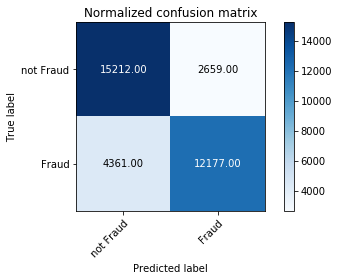

In [349]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(pd_true.values, pd_pred.values, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

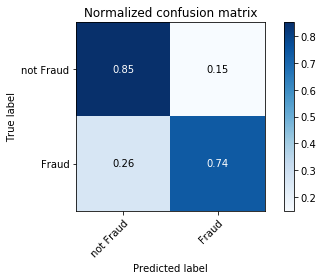

In [350]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(pd_true.values, pd_pred.values, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

In [254]:
# # Pyspark implementation
# # Instantiate metrics object
# metrics = MulticlassMetrics(predictionAndLabels)

# # Overall statistics
# precision = metrics.precision()
# recall = metrics.recall()
# f1Score = metrics.fMeasure()
# print("Summary Stats")
# print("Precision = %s" % precision)
# print("Recall = %s" % recall)
# print("F1 Score = %s" % f1Score)


### F1 score on valid

In [351]:
df_valid = df_valid.fillna(value='None', subset=cat)

In [352]:
prediction = model.transform(df_valid)

In [353]:
prediction = prediction.select('prediction')

In [ ]:
pd_pred = prediction.toPandas()
pd_pred.head()

,prediction
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
pd_true = df_valid.select('isFraud').toPandas()
pd_true.head()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(pd_true.values, pd_pred.values)
recall = recall_score(pd_true.values, pd_pred.values)
f1Score = f1_score(pd_true.values, pd_pred.values)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


In [ ]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(pd_true.values, pd_pred.values, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

In [ ]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(pd_true.values, pd_pred.values, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

### Predictions on the test set

In [329]:
df_test = df_test.fillna(value='None', subset=cat)

In [303]:
trans_id = df_test.select('TransactionID').toPandas()
trans_id.head()

,TransactionID
0,3664355.0
1,3664418.0
2,3664423.0
3,3664469.0
4,3665115.0


In [304]:
prediction_test = model.transform(df_test)

In [305]:
preds = prediction_test.select('prediction').toPandas()

In [306]:
preds.head()

,prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
final_preds = pd.concat([trans_id, preds], axis=1)
final_preds.columns = ['TransactionID', 'isFraud']
final_preds.head()

In [ ]:
# convert to pyspark
from pyspark.sql import SQLContext
sql = SQLContext(sc)
final_preds_spark = sql.createDataFrame(final_preds)

In [ ]:
path = "cos://default-donotdelete-pr-l16zufkrkht8vm.os_938e241641654cf0a8c1bb0aefbea33d_configs/test_predictions.csv"
final_preds_spark.write.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
    .option('header', 'true').save(path)

### Hyperparameter Tuning using Cross Validation

### Deep Learning

In [25]:
!pip install systemml
!pip install --upgrade https://github.com/niketanpansare/future_of_data/raw/master/systemml-1.3.0-SNAPSHOT-python.tar.gz

  Using cached https://files.pythonhosted.org/packages/29/50/a552a5aff252ae915f522e44642bb49a7b7b31677f9580cfd11bcc869976/scipy-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/c5/d2238762d780dde84a20b8c761f563fe882b88c5a5fb03c056547c442a19/scikit_learn-0.21.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e5/e6/c3fdc53aed9fa19d6ff3abf97dfad768ae3afce1b7431f7500000816bda5/numpy-1.17.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/9b/52e228545d14f14bb2a1622e225f38463c8726645165e1cb7dde95bfe6d4/pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8f/42/155696f85f344c066e17af287359c9786b436b1bf86029bb3411283274f3/joblib-0.14.0-py2.py3-none-any.

In [23]:
from systemml import MLContext, dml

In [26]:
from systemml.mllearn import Keras2DML

In [21]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout

In [ ]:
input_shape
sysml_model = Keras2DML(spark, keras_model, input_shape=input_shape, weights='weights_dir')
sysml_model.setConfigProperty('sysml.native.blas', 'openblas')
sysml_model.setConfigProperty('sysml.native.blas.directory', os.path.join(os.getcwd(),'OpenBLAS-0.2.20/'))
sysml_model.summary()
sysml_model.fit(X_train, y_train)

### Save model

In [ ]:
save(sc, path)